<a href="https://colab.research.google.com/github/LucasCalbucuraZ/MOS/blob/main/Regresion_Lineal_Multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

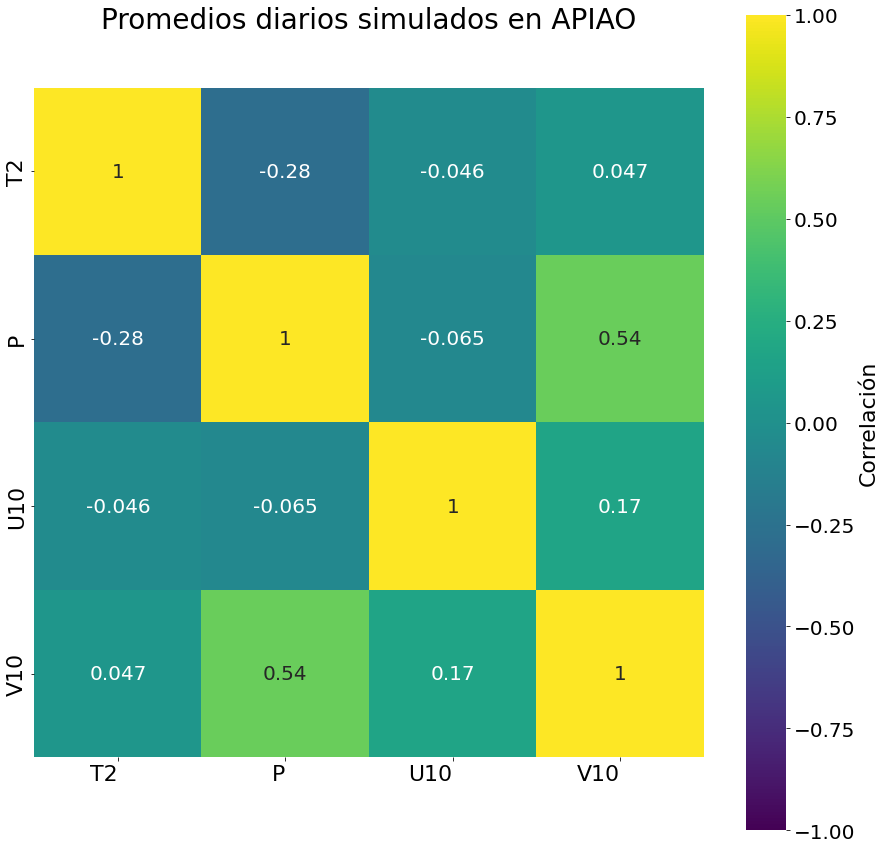

In [ ]:
# DESCRIPCIÓN: CONSTRUCCIÓN DE REGRESIÓN LINEAL MÚLTIPLE PARA CALIBRAR EL PRONÓSTICO DE TEMPERATURA DE MOSA-WRF CON ESTACIONES METEOROLÓGICAS.

# @ Lucas Calbucura Zúñiga. Lcalbucura2017@udec.cl

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import style
import seaborn as sns
import datetime
from datetime import datetime, timedelta

# Utilidades
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Cargamos los 1097 datos diarios desde GitHub, es importante que los archivos estén en formato .csv
# Hasta el momento se tienen las variables T2, T2_WRF, P_WRF, U10_WRF, V10_WRF (Mean, Max y Min)
# ==============================================================================
APIAO= pd.read_csv('https://raw.githubusercontent.com/AndresSepulveda/PHP_LucasC/main/Datos/APIAO_diario.csv'); APIAO = APIAO.drop(['Time'], axis=1)
CUCAO = pd.read_csv('https://raw.githubusercontent.com/AndresSepulveda/PHP_LucasC/main/Datos/CUCAO_diario.csv'); CUCAO = CUCAO.drop(['Time'], axis=1)
MELINKA = pd.read_csv('https://raw.githubusercontent.com/AndresSepulveda/PHP_LucasC/main/Datos/MELINKA_diario.csv'); MELINKA = MELINKA.drop(['Time'], axis=1)

# Se genera el vector fecha (desde el 1 de agosto de 2018 al 1 de agosto de 2021)
# ==============================================================================
t = np.arange(np.datetime64('2018-08-01'), np.datetime64('2021-08-02'))
time= pd.to_datetime(t)

# Para revisar si existen datos faltantes
# ==============================================================================
# CUCAO["Mean_WRF"].isnull().sum().sum() 

# Interpolamos los NaN para poder construir la regresión lineal múltiple  
# ==============================================================================
# APIAO (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Mean=APIAO["T2_WRF_mean"].interpolate(method='polynomial',order=2); APIAO["T2_WRF_mean"]=T2_WRF_Mean.to_frame()
P_WRF_Mean= APIAO["P_WRF_mean"].interpolate(method='polynomial', order=2);  APIAO["P_WRF_mean"]=P_WRF_Mean.to_frame()
U10_WRF_Mean= APIAO["U10_WRF_mean"].interpolate(method='polynomial', order=2); APIAO["U10_WRF_mean"]=U10_WRF_Mean.to_frame()
V10_WRF_Mean= APIAO["V10_WRF_mean"].interpolate(method='polynomial', order=2); APIAO["V10_WRF_mean"]=V10_WRF_Mean.to_frame()
del T2_WRF_Mean; del P_WRF_Mean; del U10_WRF_Mean; del V10_WRF_Mean;
# ==============================================================================
# CUCAO (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Mean=CUCAO["T2_WRF_mean"].interpolate(method='polynomial',order=2); CUCAO["T2_WRF_mean"]=T2_WRF_Mean.to_frame()
P_WRF_Mean= CUCAO["P_WRF_mean"].interpolate(method='polynomial', order=2);  CUCAO["P_WRF_mean"]=P_WRF_Mean.to_frame()
U10_WRF_Mean= CUCAO["U10_WRF_mean"].interpolate(method='polynomial', order=2);  CUCAO["U10_WRF_mean"]=U10_WRF_Mean.to_frame()
V10_WRF_Mean= CUCAO["V10_WRF_mean"].interpolate(method='polynomial', order=2); CUCAO["V10_WRF_mean"]=V10_WRF_Mean.to_frame()
del T2_WRF_Mean; del P_WRF_Mean; del U10_WRF_Mean; del V10_WRF_Mean; 
# ==============================================================================
# MELINKA (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Mean = MELINKA["T2_WRF_mean"].interpolate(method='polynomial',order=2); MELINKA["T2_WRF_mean"]=T2_WRF_Mean.to_frame()
P_WRF_Mean  = MELINKA["P_WRF_mean"].interpolate(method='polynomial', order=2);  MELINKA["P_WRF_mean"]=P_WRF_Mean.to_frame()
U10_WRF_Mean= MELINKA["U10_WRF_mean"].interpolate(method='polynomial', order=2); MELINKA["U10_WRF_mean"]=U10_WRF_Mean.to_frame()
V10_WRF_Mean= MELINKA["V10_WRF_mean"].interpolate(method='polynomial', order=2); MELINKA["V10_WRF_mean"]=V10_WRF_Mean.to_frame()
del T2_WRF_Mean; del P_WRF_Mean; del U10_WRF_Mean; del V10_WRF_Mean;

# Interpolamos los NaN para poder construir la regresión lineal múltiple  
# ==============================================================================
# APIAO (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Max=APIAO["T2_WRF_max"].interpolate(method='polynomial',order=2); APIAO["T2_WRF_max"]=T2_WRF_Max.to_frame()
P_WRF_Max= APIAO["P_WRF_max"].interpolate(method='polynomial', order=2);  APIAO["P_WRF_max"]=P_WRF_Max.to_frame()
U10_WRF_Max= APIAO["U10_WRF_max"].interpolate(method='polynomial', order=2); APIAO["U10_WRF_max"]=U10_WRF_Max.to_frame()
V10_WRF_Max= APIAO["V10_WRF_max"].interpolate(method='polynomial', order=2); APIAO["V10_WRF_max"]=V10_WRF_Max.to_frame()
del T2_WRF_Max; del P_WRF_Max; del U10_WRF_Max; del V10_WRF_Max;
# ==============================================================================
# CUCAO (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Max=CUCAO["T2_WRF_max"].interpolate(method='polynomial',order=2); CUCAO["T2_WRF_max"]=T2_WRF_Max.to_frame()
P_WRF_Max= CUCAO["P_WRF_max"].interpolate(method='polynomial', order=2);  CUCAO["P_WRF_max"]=P_WRF_Max.to_frame()
U10_WRF_Max= CUCAO["U10_WRF_max"].interpolate(method='polynomial', order=2);  CUCAO["U10_WRF_max"]=U10_WRF_Max.to_frame()
V10_WRF_Max= CUCAO["V10_WRF_max"].interpolate(method='polynomial', order=2); CUCAO["V10_WRF_max"]=V10_WRF_Max.to_frame()
del T2_WRF_Max; del P_WRF_Max; del U10_WRF_Max; del V10_WRF_Max; 
# ==============================================================================
# MELINKA (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Max = MELINKA["T2_WRF_max"].interpolate(method='polynomial',order=2); MELINKA["T2_WRF_max"]=T2_WRF_Max.to_frame()
P_WRF_Max  = MELINKA["P_WRF_max"].interpolate(method='polynomial', order=2);  MELINKA["P_WRF_max"]=P_WRF_Max.to_frame()
U10_WRF_Max= MELINKA["U10_WRF_max"].interpolate(method='polynomial', order=2); MELINKA["U10_WRF_max"]=U10_WRF_Max.to_frame()
V10_WRF_Max= MELINKA["V10_WRF_max"].interpolate(method='polynomial', order=2); MELINKA["V10_WRF_max"]=V10_WRF_Max.to_frame()
del T2_WRF_Max; del P_WRF_Max; del U10_WRF_Max; del V10_WRF_Max;

# Interpolamos los NaN para poder construir la regresión lineal múltiple  
# ==============================================================================
# APIAO (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Min=APIAO["T2_WRF_min"].interpolate(method='polynomial',order=2); APIAO["T2_WRF_min"]=T2_WRF_Min.to_frame()
P_WRF_Min= APIAO["P_WRF_min"].interpolate(method='polynomial', order=2);  APIAO["P_WRF_min"]=P_WRF_Min.to_frame()
U10_WRF_Min= APIAO["U10_WRF_min"].interpolate(method='polynomial', order=2); APIAO["U10_WRF_min"]=U10_WRF_Min.to_frame()
V10_WRF_Min= APIAO["V10_WRF_min"].interpolate(method='polynomial', order=2); APIAO["V10_WRF_min"]=V10_WRF_Min.to_frame()
del T2_WRF_Min; del P_WRF_Min; del U10_WRF_Min; del V10_WRF_Min;
# ==============================================================================
# CUCAO (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Min=CUCAO["T2_WRF_min"].interpolate(method='polynomial',order=2); CUCAO["T2_WRF_min"]=T2_WRF_Min.to_frame()
P_WRF_Min= CUCAO["P_WRF_min"].interpolate(method='polynomial', order=2);  CUCAO["P_WRF_min"]=P_WRF_Min.to_frame()
U10_WRF_Min= CUCAO["U10_WRF_min"].interpolate(method='polynomial', order=2);  CUCAO["U10_WRF_min"]=U10_WRF_Min.to_frame()
V10_WRF_Min= CUCAO["V10_WRF_min"].interpolate(method='polynomial', order=2); CUCAO["V10_WRF_min"]=V10_WRF_Min.to_frame()
del T2_WRF_Min; del P_WRF_Min; del U10_WRF_Min; del V10_WRF_Min; 
# ==============================================================================
# MELINKA (T2_WRF, P_WRF, U10_WRF, V10_WRF, por ahora... )
T2_WRF_Min = MELINKA["T2_WRF_min"].interpolate(method='polynomial',order=2); MELINKA["T2_WRF_min"]=T2_WRF_Min.to_frame()
P_WRF_Min  = MELINKA["P_WRF_min"].interpolate(method='polynomial', order=2);  MELINKA["P_WRF_min"]=P_WRF_Min.to_frame()
U10_WRF_Min= MELINKA["U10_WRF_min"].interpolate(method='polynomial', order=2); MELINKA["U10_WRF_min"]=U10_WRF_Min.to_frame()
V10_WRF_Min= MELINKA["V10_WRF_min"].interpolate(method='polynomial', order=2); MELINKA["V10_WRF_min"]=V10_WRF_Min.to_frame()
del T2_WRF_Min; del P_WRF_Min; del U10_WRF_Min; del V10_WRF_Min;

ESTACION = APIAO # Elegir entre APIAO, CUCAO O MELINKA 

# Seleccionamos las variables predictoras y generamos una matriz de correlación
# ==============================================================================
predictores = ESTACION.filter(['T2_WRF_mean','P_WRF_mean','U10_WRF_mean','V10_WRF_mean'], axis=1)
predictores.columns=['T2','P','U10','V10']


# Estandarizamos
# ==============================================================================
sc=StandardScaler()
predictores_std = sc.fit_transform(predictores)
predictors = pd.DataFrame(predictores_std, columns = ['T2','P','U10','V10'])

def tidy_corr_matrix(corr_mat):
    '''
    Función para generar la matriz de correlación
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

corr_matrix = predictors.select_dtypes(include=['float64', 'int']).corr(method='pearson')

# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
plt.title('Promedios diarios simulados en APIAO',fontsize=28,y=1.08)
sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = True,
    annot_kws = {"size": 20},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("viridis", as_cmap=True),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 0,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 22)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.collections[0].colorbar.set_label("Correlación",fontsize=22)
plt.savefig('APIAO_heatmap_mean.png')

In [ ]:
# División de los datos en train y test
# ==============================================================================
# Filtramos el dataframe considerando sólo los promedios diarios (ya que igual tenemos máximos y mínimos)
data = ESTACION.filter(['T2_mean','T2_WRF_mean','P_WRF_mean','U10_WRF_mean','V10_WRF_mean'], axis=1)
#X = data[['T2_WRF_mean', 'P_WRF_mean', 'U10_WRF_mean','V10_WRF_mean']] # Variables predictoras 
y = data['T2_mean'] # Variable dependiente (en este caso son las observaciones, recordar que es un problema inverso)

# Acá dividimos los datos conservando el primer 90% para entrenar el modelo derivando los coeficientes de regresión y luego
# los aplicamos en el 10% no utilizado. Lo anterior también se conoce como validación cruzada (o cross-validation) y es la
# mejor forma de cuantificar la precisión o skill de MOS (o de cualquier predicción estadística..)
X_train, X_test, y_train, y_test = train_test_split(
                                        predictores,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.9,       # 90%-10% 
                                        shuffle      = False      # División lineal ya que los datos tienen un orden temporal
                                    )

# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3296.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        11:51:39   Log-Likelihood:                -969.97
No. Observations:                 987   AIC:                             1950.
Df Residuals:                     982   BIC:                             1974.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.1677      4.867     -6.609      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# Predicciones con el 90% de los datos entrenados con intervalo de confianza del 95%
# ==============================================================================
predicciones_xtrain = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
#predicciones_xtrain.isnull().sum().sum() #para revisar los NaN

# Predicciones con el 10% restante de datos.. 
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones_xtest = modelo.predict(exog = X_test)

# Reconstruccion serie de tiempo MOS (sumamos las predicciones obtenidas con el 90% de xtrain y el 10% de xtest )
# recordar que x son las variables predictoras 
reconstruccion=pd.concat([predicciones_xtrain["mean"],
                         predicciones_xtest], 
                         axis=0
                         )
OBS =ESTACION['T2_mean'].values.reshape(-1,1)
MOS = reconstruccion.values.reshape(-1,1)


linear_regressor = LinearRegression()
linear_regressor.fit(OBS, MOS)
APIAO_pred = linear_regressor.predict(OBS)
residuos=MOS-OBS


In [ ]:
MOS_APIAO=reconstruccion
#MOS_CUCAO=reconstruccion
#MOS_MELINKA=reconstruccion

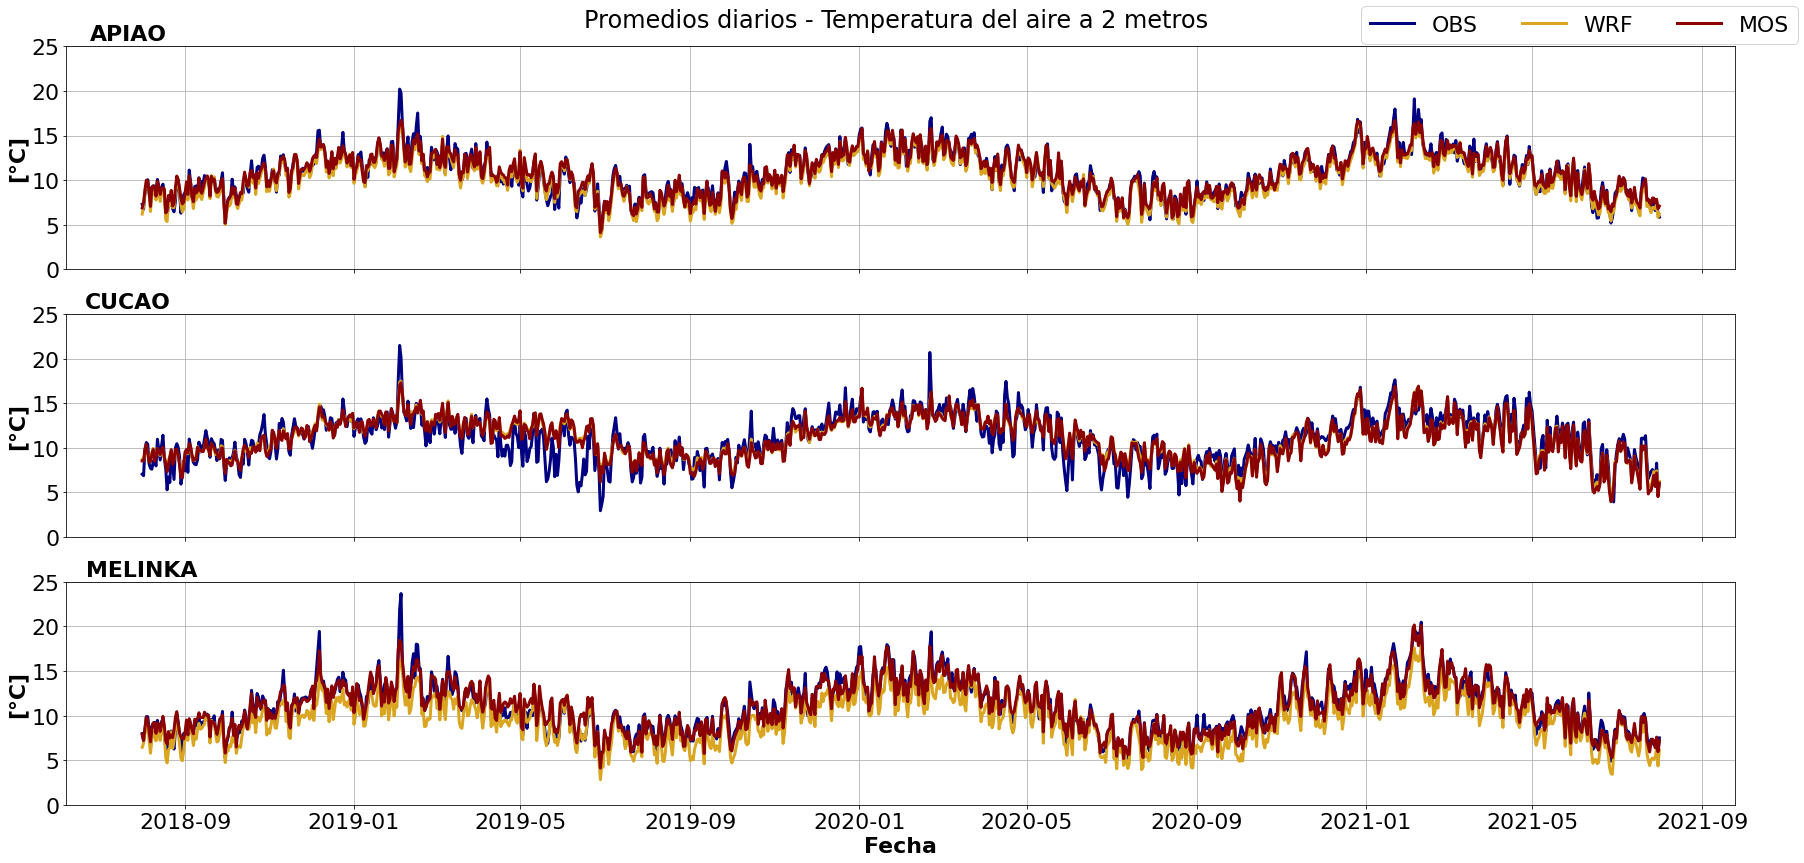

In [ ]:
# SERIES DE TIEMPO PARA LOS PROMEDIOS DIARIOS
# ======================================================================================
fig, ax = plt.subplots(3,figsize=(25,12), sharex=True)
fig.suptitle('Promedios diarios - Temperatura del aire a 2 metros',x=0.5,y=0.994,fontsize=24)
loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 
# APIAO
ax[0].plot(time,APIAO["T2_mean"],color='navy',linewidth=3,label='OBS') #Observado
ax[0].plot(time,APIAO["T2_WRF_mean"],color='goldenrod',linewidth=3,label='WRF') #Simulado 
ax[0].plot(time,MOS_APIAO,color='darkred',linewidth=3,label='MOS') #Diferencia
ax[0].set_ylabel('[°C]', fontsize=22, weight='bold')
ax[0].set_ylim(0,25)
ax[0].yaxis.set_major_locator(loc)
ax[0].yaxis.set_minor_locator(loc)
ax[0].set_title('APIAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[0].grid(True)
ax[0].legend(fontsize=22,loc='upper right',bbox_to_anchor=(1.044, 1.229),ncol=3)
# CUCAO
ax[1].plot(time,CUCAO["T2_mean"],color='navy',linewidth=3) #Observado
ax[1].plot(time,CUCAO["T2_WRF_mean"],color='goldenrod',linewidth=3) #Simulado 
ax[1].plot(time,MOS_CUCAO,color='darkred',linewidth=3) #Diferencia
ax[1].set_ylabel('[°C]', fontsize = 22, weight='bold')
ax[1].set_ylim(0,25)
ax[1].yaxis.set_major_locator(loc)
ax[1].set_title('CUCAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[1].grid(True)
# MELINKA
ax[2].plot(time,MELINKA["T2_mean"],color='navy',linewidth=3) #Observado
ax[2].plot(time,MELINKA["T2_WRF_mean"],color='goldenrod',linewidth=3) #Simulado 
ax[2].plot(time,MOS_MELINKA,color='darkred',linewidth=3) #Diferencia
ax[2].set_xlabel('Fecha', fontsize = 22, weight='bold')
ax[2].set_ylabel('[°C]', fontsize = 22, weight='bold')
ax[2].set_ylim(0,25)
ax[2].yaxis.set_major_locator(loc)
ax[2].set_title('MELINKA',fontsize=22,x=0.045, y=1, weight='bold')
ax[2].grid(True)
fig.tight_layout()
plt.savefig("T2_mean_MOS.png")

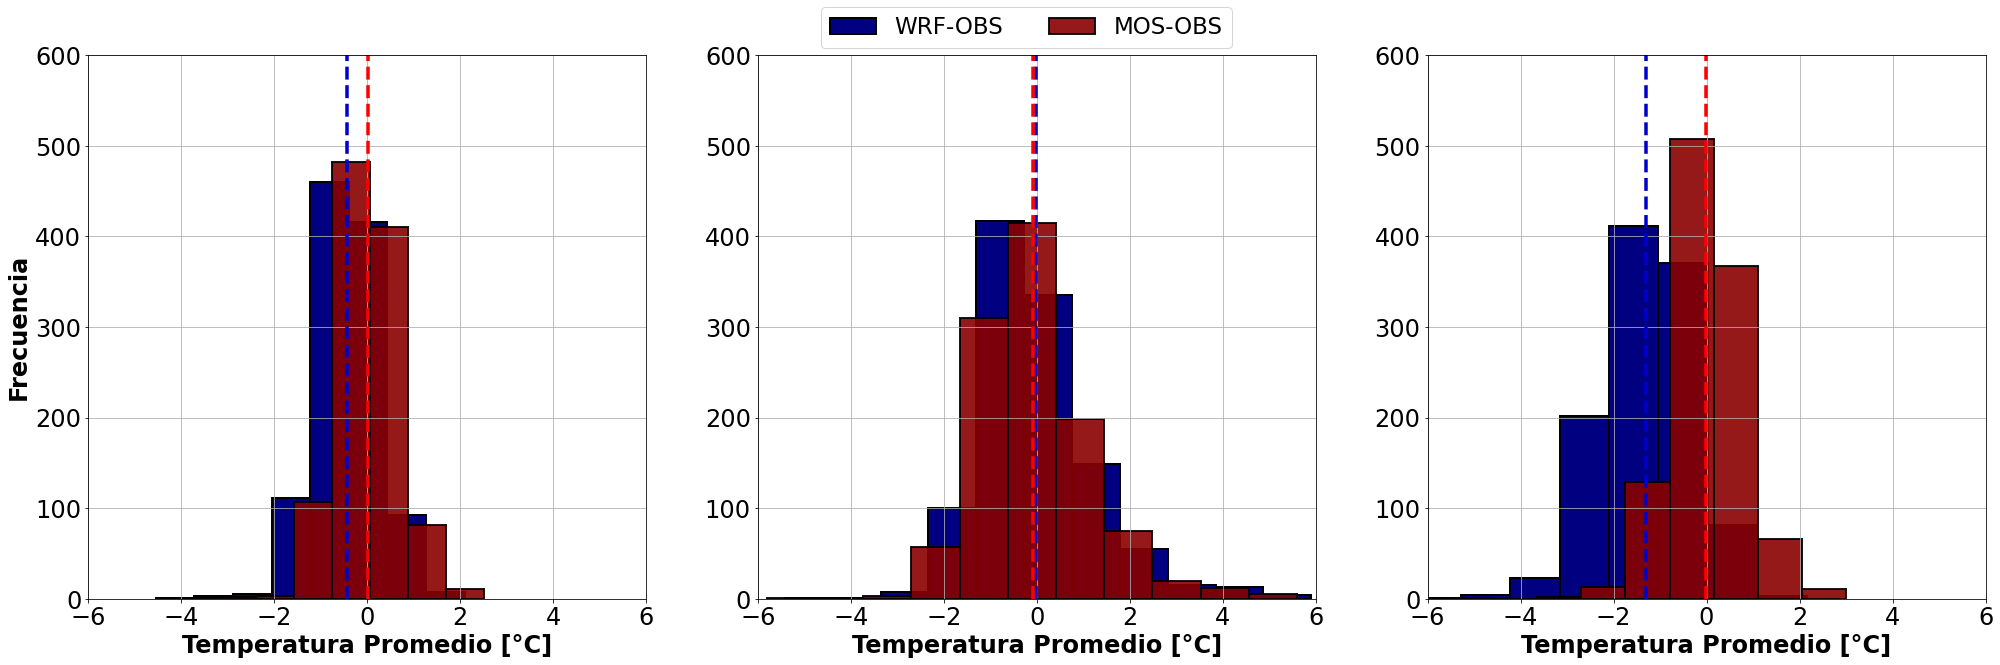

In [ ]:
# HISTOGRAMA DE LAS DIFERENCIAS
# ======================================================================================    
fig, ax = plt.subplots(1,3,figsize=(34,10),sharey=True)
plt.subplot(1,3,1) # DIFERENCIA TEMPERATURA PROMEDIO
plt.hist(APIAO['T2_WRF_mean']-APIAO['T2_mean'], bins = 8,color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((APIAO['T2_WRF_mean']-APIAO['T2_mean']).mean(), color='mediumblue', linestyle='dashed', linewidth=3.5)
plt.hist(MOS_APIAO-APIAO['T2_mean'], bins = 8,color = "darkred",edgecolor='k',alpha=0.90,linewidth=2,label='MOS-OBS')
plt.axvline((MOS_APIAO-APIAO['T2_mean']).mean(), color='red', linestyle='dashed', linewidth=3.5)
plt.xlabel('Temperatura Promedio [°C]', fontsize=24, weight='bold')
plt.ylabel('Frecuencia', fontsize=24, weight='bold')
plt.ylim(0,600); plt.xlim(-6,6) ; plt.legend(bbox_to_anchor=(2.0695, 1.11),fontsize=23,ncol=3)
plt.xticks(fontsize=24);  plt.yticks(fontsize=24);  plt.grid(True)
plt.subplot(1,3,2) # DIFERENCIA TEMPERATURA PROMEDIO
plt.hist(CUCAO['T2_WRF_mean']-CUCAO['T2_mean'], bins = 11,color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((CUCAO['T2_WRF_mean']-CUCAO['T2_mean']).mean(), color='mediumblue', linestyle='dashed', linewidth=3.5)
plt.hist(MOS_CUCAO-CUCAO['T2_mean'], bins = 11,color = "darkred",edgecolor='k',alpha=0.90,linewidth=2,label='MOS-OBS')
plt.axvline((MOS_CUCAO-CUCAO['T2_mean']).mean(), color='red', linestyle='dashed', linewidth=3.5)
plt.xlabel('Temperatura Promedio [°C]', fontsize=24, weight='bold')
plt.ylim(0,600); plt.xlim(-6,6) ;
plt.xticks(fontsize=24);  plt.yticks(fontsize=24);  plt.grid(True)

plt.subplot(1,3,3) # DIFERENCIA TEMPERATURA PROMEDIO
plt.hist(MELINKA['T2_WRF_mean']-MELINKA['T2_mean'], bins = 9,color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((MELINKA['T2_WRF_mean']-MELINKA['T2_mean']).mean(), color='mediumblue', linestyle='dashed', linewidth=3.5)
plt.hist(MOS_MELINKA-MELINKA['T2_mean'], bins = 9,color = "darkred",edgecolor='k',alpha=0.90,linewidth=2,label='MOS-OBS')
plt.axvline((MOS_MELINKA-MELINKA['T2_mean']).mean(), color='red', linestyle='dashed', linewidth=3.5)
plt.xlabel('Temperatura Promedio [°C]', fontsize=24, weight='bold')
plt.ylim(0,600); plt.xlim(-6,6) ;
plt.xticks(fontsize=24);  plt.yticks(fontsize=24);  plt.grid(True)
plt.savefig('hist_diferencias_Tmean.png')

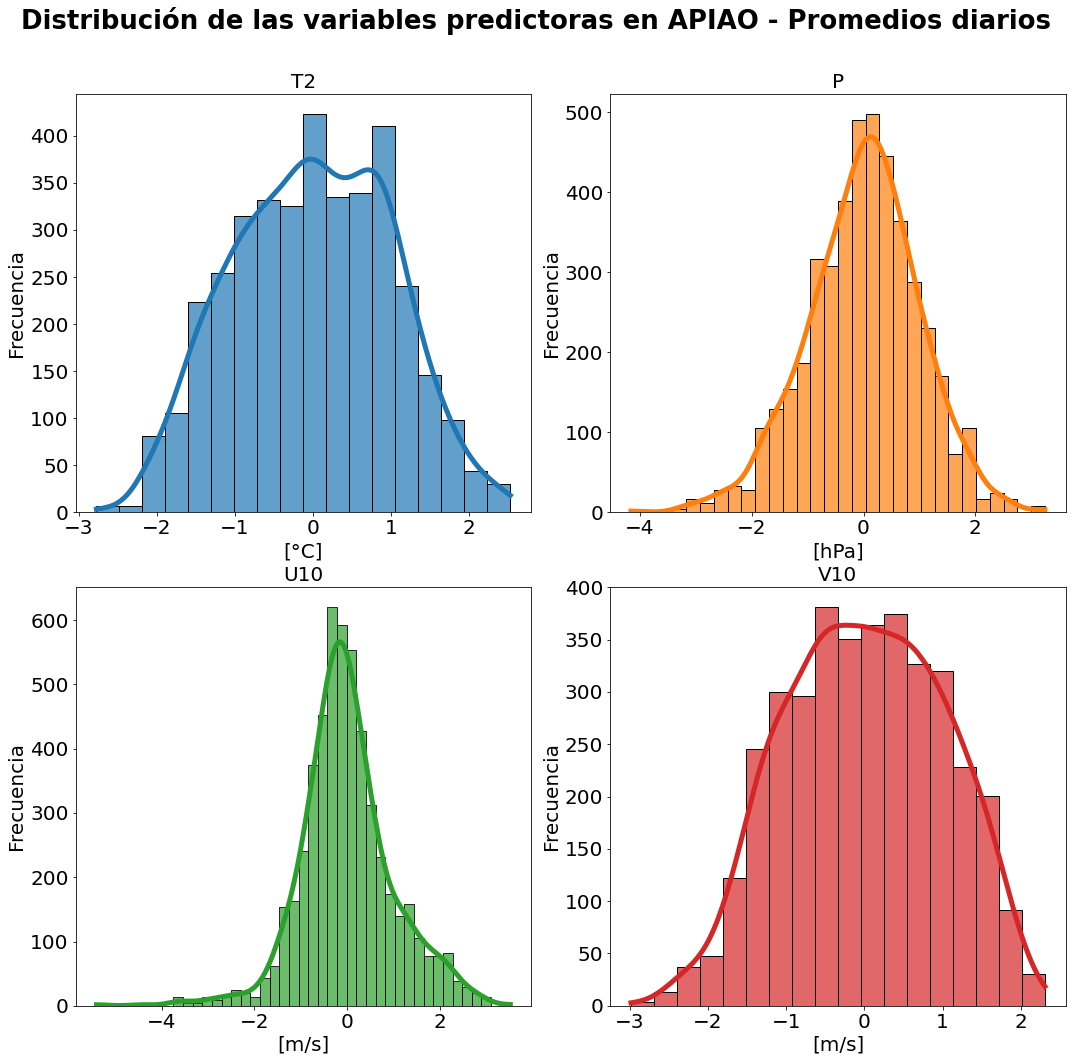

In [ ]:
# Gráfico de distribución para cada variable predictora
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axes = axes.flat
columnas_numeric = predictores.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = predictors,
        x       = colum,
        stat    = "frequency",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 5},
        alpha   = 0.7,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_ylabel("Frecuencia",fontsize=20)

    axes[0].set_xlabel("[°C]",fontsize=20);  axes[1].set_xlabel("[hPa]",fontsize=20)
    axes[2].set_xlabel("[m/s]",fontsize=20); axes[3].set_xlabel("[m/s]",fontsize=20)
    axes[0].set_title("T2",fontsize=20);   axes[1].set_title("P",fontsize=20)
    axes[2].set_title("U10",fontsize=20);  axes[3].set_title("V10",fontsize=20)

fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución de las variables predictoras en APIAO - Promedios diarios', fontsize = 26, fontweight = "bold");
plt.savefig('APIAOvariablespredictoras_Mean.png')